## Ref 

- https://medium.com/machine-learning-world/neural-networks-for-algorithmic-trading-1-2-correct-time-series-forecasting-backtesting-9776bfd9e589


- https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [1]:
# ops 
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
%pylab inline

# ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D
from keras.callbacks import Callback


Populating the interactive namespace from numpy and matplotlib


/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:




# data prepare 
def get_data(fine_name):
	print (fine_name)
	df = pd.read_csv('data/{}.csv'.format(fine_name))
	print (df.head())
	return df  

def col_fix(df):
    df = df.drop('Unnamed: 0', axis=1) 
    print (df.columns)
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    #df['Date'] = pd.to_datetime(df['Date'] )
    print (df.head())
    return df 



def get_train_data(df):
	#df_expo = df[df.drop_off_addr == 'expo']
	#dataset = df_expo.groupby('timestamp_live_vec_table')\
	#				 .median()[['lag_idle_day']]\
	#				 .values
	#dataset = df[['Volume','High','Open']].values.astype('float32')
	dataset = df[['Open']].values.astype('float32')
	#print (shape(dataset))
	print (dataset) 
	return dataset



# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)




#------------------------
# DL 


def one_input_LSTM_model_1(dataset):
	# normalize the dataset
	scaler = MinMaxScaler(feature_range=(0, 1))
	dataset = scaler.fit_transform(dataset)
	# split into train and test sets
	train_size = int(len(dataset) * 0.67)
	test_size = len(dataset) - train_size
	train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
	# reshape into X=t and Y=t+1
	look_back = 1
	trainX, trainY = create_dataset(train, look_back)
	testX, testY = create_dataset(test, look_back)
	# reshape input to be [samples, time steps, features]
	trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
	testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
	# create and fit the LSTM network
	model = Sequential()
	model.add(LSTM(4, input_shape=(1, look_back)))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
	# make predictions
	trainPredict = model.predict(trainX)
	testPredict = model.predict(testX)
	# invert predictions
	trainPredict = scaler.inverse_transform(trainPredict)
	trainY = scaler.inverse_transform([trainY])
	testPredict = scaler.inverse_transform(testPredict)
	testY = scaler.inverse_transform([testY])
	# calculate root mean squared error
	trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
	print('Train Score: %.2f RMSE' % (trainScore))
	testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
	print('Test Score: %.2f RMSE' % (testScore))
	# shift train predictions for plotting
	trainPredictPlot = np.empty_like(dataset)
	trainPredictPlot[:, :] = np.nan
	trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
	# shift test predictions for plotting
	testPredictPlot = np.empty_like(dataset)
	testPredictPlot[:, :] = np.nan
	testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
	print (model.summary())
	return  dataset,trainPredict,testPredict,trainPredictPlot,testPredictPlot



def one_input_LSTM_model_1_(dataset, lookback):
	# normalize the dataset
	scaler = MinMaxScaler(feature_range=(0, 1))
	dataset = scaler.fit_transform(dataset)
	# split into train and test sets
	train_size = int(len(dataset) * 0.67)
	test_size = len(dataset) - train_size
	train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
	# reshape into X=t and Y=t+1
	look_back = lookback
	trainX, trainY = create_dataset(train, look_back)
	testX, testY = create_dataset(test, look_back)
	# reshape input to be [samples, time steps, features]
	trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
	testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
	# create and fit the LSTM network
	model = Sequential()
	model.add(LSTM(4, input_shape=(1, look_back)))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
	# make predictions
	trainPredict = model.predict(trainX)
	testPredict = model.predict(testX)
	# invert predictions
	trainPredict = scaler.inverse_transform(trainPredict)
	trainY = scaler.inverse_transform([trainY])
	testPredict = scaler.inverse_transform(testPredict)
	testY = scaler.inverse_transform([testY])
	# calculate root mean squared error
	trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
	print('Train Score: %.2f RMSE' % (trainScore))
	testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
	print('Test Score: %.2f RMSE' % (testScore))
	# shift train predictions for plotting
	trainPredictPlot = np.empty_like(dataset)
	trainPredictPlot[:, :] = np.nan
	trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
	# shift test predictions for plotting
	testPredictPlot = np.empty_like(dataset)
	testPredictPlot[:, :] = np.nan
	testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
	print (model.summary())
	return  dataset,trainPredict,testPredict,trainPredictPlot,testPredictPlot





def one_input_LSTM_model_2(dataset):
	# normalize the dataset
	scaler = MinMaxScaler(feature_range=(0, 1))
	dataset = scaler.fit_transform(dataset)
	# split into train and test sets
	train_size = int(len(dataset) * 0.67)
	test_size = len(dataset) - train_size
	train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
	# reshape into X=t and Y=t+1
	look_back = 1
	trainX, trainY = create_dataset(train, look_back)
	testX, testY = create_dataset(test, look_back)
	# reshape input to be [samples, time steps, features]
	trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
	testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
	# create and fit the LSTM network
	model = Sequential()
	model.add(LSTM(4, return_sequences=True,input_shape=(1, look_back)))
	model.add(LSTM(4, input_shape=(1, look_back)))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
	# make predictions
	trainPredict = model.predict(trainX)
	testPredict = model.predict(testX)
	# invert predictions
	trainPredict = scaler.inverse_transform(trainPredict)
	trainY = scaler.inverse_transform([trainY])
	testPredict = scaler.inverse_transform(testPredict)
	testY = scaler.inverse_transform([testY])
	# calculate root mean squared error
	trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
	print('Train Score: %.2f RMSE' % (trainScore))
	testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
	print('Test Score: %.2f RMSE' % (testScore))
	# shift train predictions for plotting
	trainPredictPlot = np.empty_like(dataset)
	trainPredictPlot[:, :] = np.nan
	trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
	# shift test predictions for plotting
	testPredictPlot = np.empty_like(dataset)
	testPredictPlot[:, :] = np.nan
	testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
	print (model.summary())
	return  dataset,trainPredict,testPredict,trainPredictPlot,testPredictPlot

#---------------------------------------


In [3]:
# LSTM model 1

df_FB = get_data('FB')
df_FB_ = col_fix(df_FB)
dataset = get_train_data(df_FB_)
dataset,trainPredict,testPredict,trainPredictPlot,testPredictPlot = one_input_LSTM_model_1(dataset)



FB
   Unnamed: 0        Date    Open    High     Low   Close    Volume
0           0  2018-04-12  166.98  167.45  163.10  163.87  38262956
1           1  2018-04-11  165.36  168.65  163.25  166.32  56144633
2           2  2018-04-10  157.93  165.98  157.01  165.04  58947041
3           3  2018-04-09  157.82  160.53  156.04  157.93  34915227
4           4  2018-04-06  157.73  161.42  156.81  157.20  41644812
Index(['Date', ' Open', ' High', ' Low', ' Close', ' Volume'], dtype='object')
         Date    Open    High     Low   Close    Volume
0  2018-04-12  166.98  167.45  163.10  163.87  38262956
1  2018-04-11  165.36  168.65  163.25  166.32  56144633
2  2018-04-10  157.93  165.98  157.01  165.04  58947041
3  2018-04-09  157.82  160.53  156.04  157.93  34915227
4  2018-04-06  157.73  161.42  156.81  157.20  41644812
[[166.98]
 [165.36]
 [157.93]
 ...
 [ 32.61]
 [ 36.53]
 [ 42.05]]
Epoch 1/20
 - 5s - loss: 0.0488
Epoch 2/20
 - 5s - loss: 0.0057
Epoch 3/20
 - 3s - loss: 3.9093e-04
Epoch 4/

FB
   Unnamed: 0        Date    Open    High     Low   Close    Volume
0           0  2018-04-12  166.98  167.45  163.10  163.87  38262956
1           1  2018-04-11  165.36  168.65  163.25  166.32  56144633
2           2  2018-04-10  157.93  165.98  157.01  165.04  58947041
3           3  2018-04-09  157.82  160.53  156.04  157.93  34915227
4           4  2018-04-06  157.73  161.42  156.81  157.20  41644812
Index(['Date', ' Open', ' High', ' Low', ' Close', ' Volume'], dtype='object')
         Date    Open    High     Low   Close    Volume
0  2018-04-12  166.98  167.45  163.10  163.87  38262956
1  2018-04-11  165.36  168.65  163.25  166.32  56144633
2  2018-04-10  157.93  165.98  157.01  165.04  58947041
3  2018-04-09  157.82  160.53  156.04  157.93  34915227
4  2018-04-06  157.73  161.42  156.81  157.20  41644812
[[166.98]
 [165.36]
 [157.93]
 ...
 [ 32.61]
 [ 36.53]
 [ 42.05]]
1
Epoch 1/20
 - 4s - loss: 0.0652
Epoch 2/20
 - 3s - loss: 0.0101
Epoch 3/20
 - 3s - loss: 0.0015
Epoch 4/20

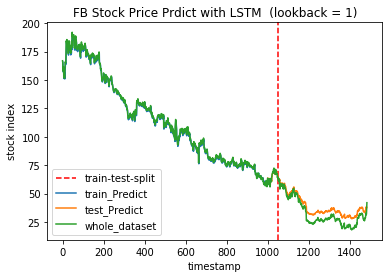

2
Epoch 1/20
 - 4s - loss: 0.0271
Epoch 2/20
 - 3s - loss: 6.8865e-04
Epoch 3/20
 - 3s - loss: 2.1433e-04
Epoch 4/20
 - 3s - loss: 2.1066e-04
Epoch 5/20
 - 3s - loss: 2.0805e-04
Epoch 6/20
 - 3s - loss: 2.0238e-04
Epoch 7/20
 - 3s - loss: 1.9996e-04
Epoch 8/20
 - 3s - loss: 1.9418e-04
Epoch 9/20
 - 3s - loss: 1.9074e-04
Epoch 10/20
 - 3s - loss: 1.8203e-04
Epoch 11/20
 - 3s - loss: 1.8480e-04
Epoch 12/20
 - 3s - loss: 1.8992e-04
Epoch 13/20
 - 3s - loss: 1.8610e-04
Epoch 14/20
 - 3s - loss: 1.8055e-04
Epoch 15/20
 - 3s - loss: 1.7504e-04
Epoch 16/20
 - 3s - loss: 1.7992e-04
Epoch 17/20
 - 3s - loss: 1.7937e-04
Epoch 18/20
 - 3s - loss: 1.7904e-04
Epoch 19/20
 - 3s - loss: 1.8201e-04
Epoch 20/20
 - 3s - loss: 1.7617e-04
Train Score: 0.01 RMSE
Test Score: 0.03 RMSE
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4)                 112       
____________________________

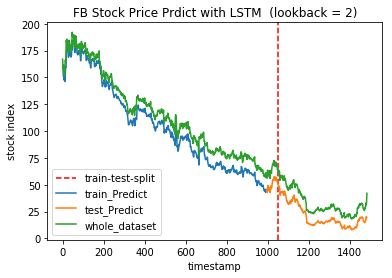

3
Epoch 1/20
 - 4s - loss: 0.0742
Epoch 2/20
 - 3s - loss: 0.0028
Epoch 3/20
 - 3s - loss: 2.2627e-04
Epoch 4/20
 - 3s - loss: 2.0264e-04
Epoch 5/20
 - 3s - loss: 2.0029e-04
Epoch 6/20
 - 3s - loss: 2.0409e-04
Epoch 7/20
 - 3s - loss: 1.9953e-04
Epoch 8/20
 - 3s - loss: 2.0672e-04
Epoch 9/20
 - 3s - loss: 2.0365e-04
Epoch 10/20
 - 3s - loss: 2.0448e-04
Epoch 11/20
 - 3s - loss: 2.0330e-04
Epoch 12/20
 - 3s - loss: 2.0632e-04
Epoch 13/20
 - 3s - loss: 2.0425e-04
Epoch 14/20
 - 3s - loss: 1.9666e-04
Epoch 15/20
 - 5s - loss: 1.9844e-04
Epoch 16/20
 - 5s - loss: 1.9436e-04
Epoch 17/20
 - 5s - loss: 1.9106e-04
Epoch 18/20
 - 4s - loss: 1.9321e-04
Epoch 19/20
 - 4s - loss: 1.9102e-04
Epoch 20/20
 - 4s - loss: 1.9047e-04
Train Score: 0.01 RMSE
Test Score: 0.05 RMSE
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 4)                 128       
________________________________

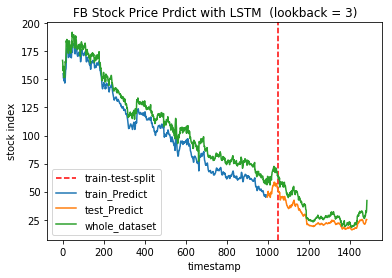

4
Epoch 1/20
 - 5s - loss: 0.0231
Epoch 2/20
 - 3s - loss: 2.6342e-04
Epoch 3/20
 - 3s - loss: 2.1370e-04
Epoch 4/20
 - 3s - loss: 2.2137e-04
Epoch 5/20
 - 3s - loss: 2.2361e-04
Epoch 6/20
 - 3s - loss: 2.2477e-04
Epoch 7/20
 - 3s - loss: 2.2589e-04
Epoch 8/20
 - 3s - loss: 2.1825e-04
Epoch 9/20
 - 3s - loss: 2.2131e-04
Epoch 10/20
 - 3s - loss: 2.0714e-04
Epoch 11/20
 - 3s - loss: 2.1030e-04
Epoch 12/20
 - 3s - loss: 2.0342e-04
Epoch 13/20
 - 4s - loss: 1.9199e-04
Epoch 14/20
 - 5s - loss: 1.9376e-04
Epoch 15/20
 - 3s - loss: 1.9436e-04
Epoch 16/20
 - 3s - loss: 2.0121e-04
Epoch 17/20
 - 3s - loss: 1.9233e-04
Epoch 18/20
 - 3s - loss: 1.9370e-04
Epoch 19/20
 - 3s - loss: 1.8630e-04
Epoch 20/20
 - 3s - loss: 1.7842e-04
Train Score: 0.01 RMSE
Test Score: 0.03 RMSE
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 4)                 144       
____________________________

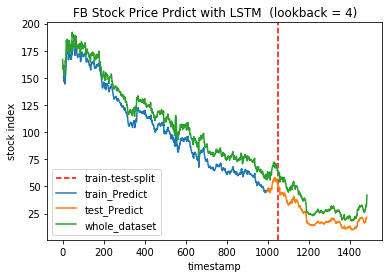

5
Epoch 1/20
 - 6s - loss: 0.0652
Epoch 2/20
 - 3s - loss: 8.2713e-04
Epoch 3/20
 - 3s - loss: 3.1760e-04
Epoch 4/20
 - 4s - loss: 3.0060e-04
Epoch 5/20
 - 3s - loss: 2.8759e-04
Epoch 6/20
 - 4s - loss: 2.8268e-04
Epoch 7/20
 - 3s - loss: 2.6887e-04
Epoch 8/20
 - 4s - loss: 2.5507e-04
Epoch 9/20
 - 4s - loss: 2.5559e-04
Epoch 10/20
 - 4s - loss: 2.4238e-04
Epoch 11/20
 - 4s - loss: 2.4470e-04
Epoch 12/20
 - 3s - loss: 2.3198e-04
Epoch 13/20
 - 3s - loss: 2.3043e-04
Epoch 14/20
 - 3s - loss: 2.2513e-04
Epoch 15/20
 - 3s - loss: 2.1025e-04
Epoch 16/20
 - 3s - loss: 1.9723e-04
Epoch 17/20
 - 3s - loss: 2.1579e-04
Epoch 18/20
 - 3s - loss: 1.9535e-04
Epoch 19/20
 - 4s - loss: 2.0861e-04
Epoch 20/20
 - 4s - loss: 1.9647e-04
Train Score: 0.02 RMSE
Test Score: 0.03 RMSE
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 4)                 160       
____________________________

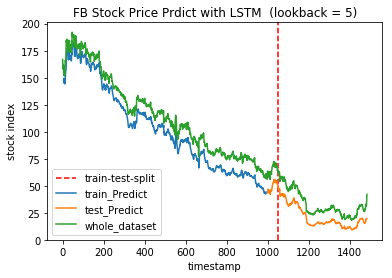

6
Epoch 1/20
 - 5s - loss: 0.0251
Epoch 2/20
 - 3s - loss: 3.5613e-04
Epoch 3/20
 - 4s - loss: 3.2371e-04
Epoch 4/20
 - 3s - loss: 3.0951e-04
Epoch 5/20
 - 3s - loss: 2.9679e-04
Epoch 6/20
 - 3s - loss: 2.9759e-04
Epoch 7/20
 - 3s - loss: 3.0018e-04
Epoch 8/20
 - 4s - loss: 2.8437e-04
Epoch 9/20
 - 4s - loss: 2.8650e-04
Epoch 10/20
 - 3s - loss: 2.8461e-04
Epoch 11/20
 - 3s - loss: 2.7730e-04
Epoch 12/20
 - 3s - loss: 2.4668e-04
Epoch 13/20
 - 3s - loss: 2.5349e-04
Epoch 14/20
 - 3s - loss: 2.5476e-04
Epoch 15/20
 - 3s - loss: 2.6333e-04
Epoch 16/20
 - 3s - loss: 2.4708e-04
Epoch 17/20
 - 3s - loss: 2.4061e-04
Epoch 18/20
 - 4s - loss: 2.3272e-04
Epoch 19/20
 - 4s - loss: 2.2955e-04
Epoch 20/20
 - 3s - loss: 2.3855e-04
Train Score: 0.01 RMSE
Test Score: 0.04 RMSE
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 4)                 176       
____________________________

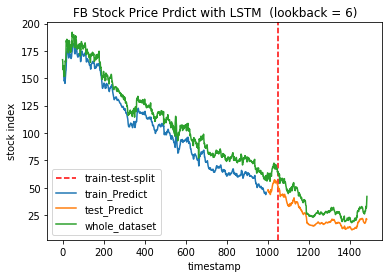

7
Epoch 1/20
 - 5s - loss: 0.0236
Epoch 2/20
 - 3s - loss: 3.4811e-04
Epoch 3/20
 - 3s - loss: 3.4185e-04
Epoch 4/20
 - 3s - loss: 3.3222e-04
Epoch 5/20
 - 3s - loss: 3.3371e-04
Epoch 6/20
 - 3s - loss: 3.5031e-04
Epoch 7/20
 - 3s - loss: 3.3054e-04
Epoch 8/20
 - 3s - loss: 3.2194e-04
Epoch 9/20
 - 4s - loss: 2.9003e-04
Epoch 10/20
 - 3s - loss: 2.9640e-04
Epoch 11/20
 - 3s - loss: 2.7361e-04
Epoch 12/20
 - 3s - loss: 2.6388e-04
Epoch 13/20
 - 3s - loss: 2.5491e-04
Epoch 14/20
 - 3s - loss: 2.4003e-04
Epoch 15/20
 - 4s - loss: 2.3237e-04
Epoch 16/20
 - 6s - loss: 2.1464e-04
Epoch 17/20
 - 5s - loss: 2.1283e-04
Epoch 18/20
 - 6s - loss: 2.1273e-04
Epoch 19/20
 - 4s - loss: 2.0075e-04
Epoch 20/20
 - 4s - loss: 2.0480e-04
Train Score: 0.01 RMSE
Test Score: 0.05 RMSE
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 4)                 192       
____________________________

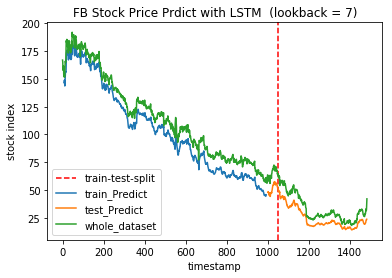

8
Epoch 1/20
 - 6s - loss: 0.0234
Epoch 2/20
 - 3s - loss: 4.2540e-04
Epoch 3/20
 - 4s - loss: 3.8743e-04
Epoch 4/20
 - 4s - loss: 3.6854e-04
Epoch 5/20
 - 3s - loss: 3.7008e-04
Epoch 6/20
 - 4s - loss: 3.4951e-04
Epoch 7/20
 - 4s - loss: 3.3694e-04
Epoch 8/20
 - 3s - loss: 3.2327e-04
Epoch 9/20
 - 3s - loss: 3.0765e-04
Epoch 10/20
 - 4s - loss: 3.0930e-04
Epoch 11/20
 - 3s - loss: 2.8588e-04
Epoch 12/20
 - 4s - loss: 2.7263e-04
Epoch 13/20
 - 4s - loss: 2.6916e-04
Epoch 14/20
 - 4s - loss: 2.6336e-04
Epoch 15/20
 - 5s - loss: 2.5175e-04
Epoch 16/20
 - 4s - loss: 2.5734e-04
Epoch 17/20
 - 5s - loss: 2.4443e-04
Epoch 18/20
 - 3s - loss: 2.4503e-04
Epoch 19/20
 - 4s - loss: 2.4709e-04
Epoch 20/20
 - 3s - loss: 2.1952e-04
Train Score: 0.01 RMSE
Test Score: 0.03 RMSE
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 4)                 208       
____________________________

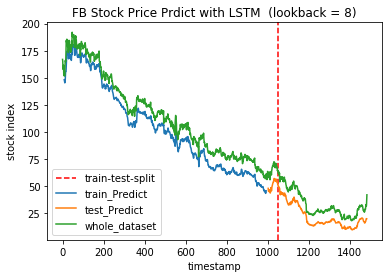

9
Epoch 1/20
 - 6s - loss: 0.0259
Epoch 2/20
 - 4s - loss: 3.7095e-04
Epoch 3/20
 - 4s - loss: 3.7127e-04
Epoch 4/20
 - 3s - loss: 3.6772e-04
Epoch 5/20
 - 3s - loss: 3.5939e-04
Epoch 6/20
 - 3s - loss: 3.2847e-04
Epoch 7/20
 - 3s - loss: 3.3334e-04
Epoch 8/20
 - 3s - loss: 2.9895e-04
Epoch 9/20
 - 3s - loss: 3.0163e-04
Epoch 10/20
 - 3s - loss: 2.7388e-04
Epoch 11/20
 - 3s - loss: 2.7105e-04
Epoch 12/20
 - 3s - loss: 2.5721e-04
Epoch 13/20
 - 3s - loss: 2.5615e-04
Epoch 14/20
 - 3s - loss: 2.3945e-04
Epoch 15/20
 - 3s - loss: 2.4382e-04
Epoch 16/20
 - 3s - loss: 2.2595e-04
Epoch 17/20
 - 3s - loss: 2.2974e-04
Epoch 18/20
 - 3s - loss: 2.0998e-04
Epoch 19/20
 - 3s - loss: 2.3211e-04
Epoch 20/20
 - 3s - loss: 2.1623e-04
Train Score: 0.01 RMSE
Test Score: 0.03 RMSE
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 4)                 224       
____________________________

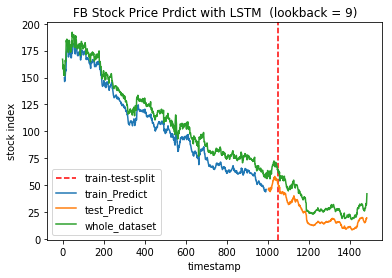

In [4]:
# for loop train the model and do the prediction with lookback 1 -> 5 


df_FB = get_data('FB')
df_FB_ = col_fix(df_FB)
dataset = get_train_data(df_FB_)
for k in range(1,10):
    print (k)
    dataset,trainPredict,testPredict,trainPredictPlot,testPredictPlot = one_input_LSTM_model_1_(dataset,lookback=k)
    plt.axvline(x=1050, color='r', linestyle='--')
    #plt.title('predict with lookback = {}'.format(k))
    if k > 1 :
        plt.plot(trainPredictPlot*187)
        plt.plot(testPredictPlot*187)
        plt.plot( df_FB_[['Open']])
        plt.legend(['train-test-split','train_Predict', 'test_Predict','whole_dataset'])
        plt.title('FB Stock Price Prdict with LSTM  (lookback = {})'.format(k))
        plt.xlabel('timestamp')
        plt.ylabel('stock index')
        plt.show()
    else:
        plt.plot(trainPredictPlot)
        plt.plot(testPredictPlot)
        plt.plot( df_FB_[['Open']])
        plt.legend(['train-test-split','train_Predict', 'test_Predict','whole_dataset'])
        plt.title('FB Stock Price Prdict with LSTM  (lookback = {})'.format(k))
        plt.xlabel('timestamp')
        plt.ylabel('stock index')
        plt.show()
        



In [5]:
for k in range(1,3):
    print (120+k)

121
122


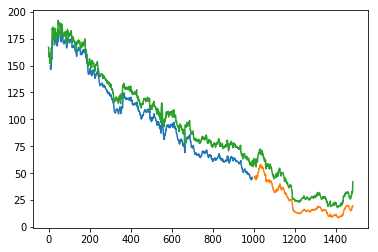

In [6]:
plt.plot(trainPredictPlot*187)
plt.plot(testPredictPlot*187)
plt.plot( df_FB_[['Open']])

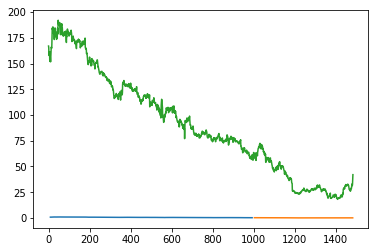

In [7]:

plt.plot(trainPredictPlot)
#plt.plot(trainPredict)
plt.plot(testPredictPlot)
#plt.plot(testPredict)
#plt.xlim(900,1400)
plt.plot( df_FB_[['Open']])

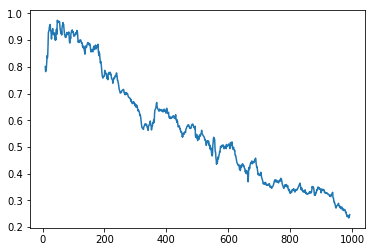

In [8]:

plt.plot(trainPredictPlot)


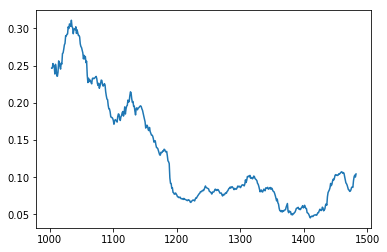

In [9]:
plt.plot(testPredictPlot)

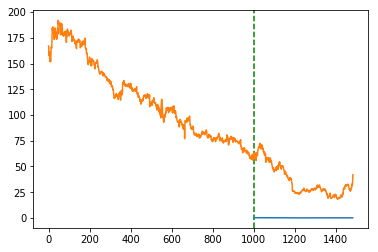

In [10]:
plt.axvline(x=1000, color='g', linestyle='--')
plt.plot(testPredictPlot)
plt.plot( df_FB_[['Open']])

In [11]:
[trainPredictPlot,testPredictPlot]

[array([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], dtype=float32), array([[       nan],
        [       nan],
        [       nan],
        ...,
        [0.10016929],
        [0.10435014],
        [       nan]], dtype=float32)]

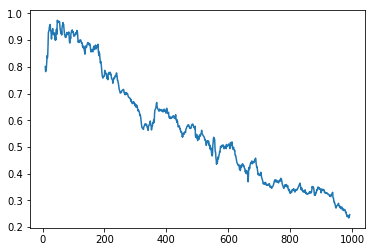

In [12]:
plt.plot(trainPredictPlot)

FB
   Unnamed: 0        Date    Open    High     Low   Close    Volume
0           0  2018-04-12  166.98  167.45  163.10  163.87  38262956
1           1  2018-04-11  165.36  168.65  163.25  166.32  56144633
2           2  2018-04-10  157.93  165.98  157.01  165.04  58947041
3           3  2018-04-09  157.82  160.53  156.04  157.93  34915227
4           4  2018-04-06  157.73  161.42  156.81  157.20  41644812
Index(['Date', ' Open', ' High', ' Low', ' Close', ' Volume'], dtype='object')
         Date    Open    High     Low   Close    Volume
0  2018-04-12  166.98  167.45  163.10  163.87  38262956
1  2018-04-11  165.36  168.65  163.25  166.32  56144633
2  2018-04-10  157.93  165.98  157.01  165.04  58947041
3  2018-04-09  157.82  160.53  156.04  157.93  34915227
4  2018-04-06  157.73  161.42  156.81  157.20  41644812
[[166.98]
 [165.36]
 [157.93]
 ...
 [ 32.61]
 [ 36.53]
 [ 42.05]]
Epoch 1/20
 - 8s - loss: 0.0544
Epoch 2/20
 - 5s - loss: 0.0025
Epoch 3/20
 - 4s - loss: 2.0460e-04
Epoch 4/

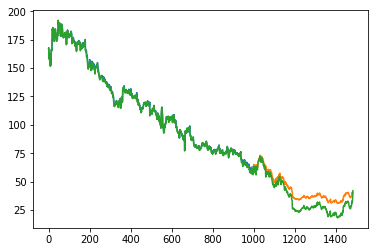

In [13]:
# LSTM model 2

df_FB = get_data('FB')
df_FB_ = col_fix(df_FB)
dataset = get_train_data(df_FB_)
dataset,trainPredict,testPredict,trainPredictPlot,testPredictPlot = one_input_LSTM_model_2(dataset)





plt.plot(trainPredictPlot)
#plt.plot(trainPredict)
plt.plot(testPredictPlot)
#plt.plot(testPredict)
#plt.xlim(900,1400)
plt.plot( df_FB_[['Open']])

In [14]:
for epoch in range(5):
    print (epoch)


0
1
2
3
4


In [15]:
dataset

array([[0.8559439 ],
       [0.84663147],
       [0.80392045],
       ...,
       [0.08352496],
       [0.10605887],
       [0.1377903 ]], dtype=float32)

In [16]:
#one_input_LSTM(dataset)

In [17]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/20
 - 5s - loss: 0.0866
Epoch 2/20
 - 3s - loss: 0.0166
Epoch 3/20
 - 3s - loss: 0.0033
Epoch 4/20
 - 3s - loss: 2.3161e-04
Epoch 5/20
 - 3s - loss: 1.4049e-04
Epoch 6/20
 - 3s - loss: 1.4514e-04
Epoch 7/20
 - 3s - loss: 1.4771e-04
Epoch 8/20
 - 3s - loss: 1.5330e-04
Epoch 9/20
 - 3s - loss: 1.5969e-04
Epoch 10/20
 - 3s - loss: 1.5522e-04
Epoch 11/20
 - 3s - loss: 1.5817e-04
Epoch 12/20
 - 3s - loss: 1.5662e-04
Epoch 13/20
 - 3s - loss: 1.5590e-04
Epoch 14/20
 - 3s - loss: 1.6109e-04
Epoch 15/20
 - 3s - loss: 1.5406e-04
Epoch 16/20
 - 3s - loss: 1.5474e-04
Epoch 17/20
 - 3s - loss: 1.6037e-04
Epoch 18/20
 - 3s - loss: 1.5425e-04
Epoch 19/20
 - 3s - loss: 1.5284e-04
Epoch 20/20
 - 3s - loss: 1.5919e-04


In [18]:
trainX

array([[[0.8559438 ]],

       [[0.84663135]],

       [[0.8039203 ]],

       [[0.8032881 ]],

       [[0.8027707 ]],

       [[0.82478726]],

       [[0.7699758 ]],

       [[0.79598755]],

       [[0.8032305 ]],

       [[0.78793967]],

       [[0.76782006]],

       [[0.7946079 ]],

       [[0.82053345]],

       [[0.84709126]],

       [[0.8510577 ]],

       [[0.8434122 ]],

       [[0.8587606 ]],

       [[0.91360074]],

       [[0.9565992 ]],

       [[0.9494136 ]],

       [[0.9457347 ]],

       [[0.96303743]],

       [[0.96085304]],

       [[0.95326513]],

       [[0.9512531 ]],

       [[0.92354566]],

       [[0.9410209 ]],

       [[0.90894455]],

       [[0.8922165 ]],

       [[0.92509764]],

       [[0.9440101 ]],

       [[0.9563692 ]],

       [[0.95711654]],

       [[0.93021375]],

       [[0.9233156 ]],

       [[0.91187626]],

       [[0.90647274]],

       [[0.9249827 ]],

       [[0.93366283]],

       [[0.89313626]],

       [[0.9056104 ]],

       [[0.91388

In [19]:
trainY

array([0.84663135, 0.8039203 , 0.8032881 , 0.8027707 , 0.82478726,
       0.7699758 , 0.79598755, 0.8032305 , 0.78793967, 0.76782006,
       0.7946079 , 0.82053345, 0.84709126, 0.8510577 , 0.8434122 ,
       0.8587606 , 0.91360074, 0.9565992 , 0.9494136 , 0.9457347 ,
       0.96303743, 0.96085304, 0.95326513, 0.9512531 , 0.92354566,
       0.9410209 , 0.90894455, 0.8922165 , 0.92509764, 0.9440101 ,
       0.9563692 , 0.95711654, 0.93021375, 0.9233156 , 0.91187626,
       0.90647274, 0.9249827 , 0.93366283, 0.89313626, 0.9056104 ,
       0.91388816, 0.9006668 , 0.93659455, 0.9546446 , 0.9225684 ,
       0.97062534, 1.        , 0.9780409 , 0.9789031 , 0.97461015,
       0.9810875 , 0.9753391 , 0.97648877, 0.9876408 , 0.9655668 ,
       0.93538743, 0.93567485, 0.9200391 , 0.9265347 , 0.93941134,
       0.91963667, 0.9790756 , 0.9706829 , 0.9808001 , 0.97217745,
       0.9629224 , 0.95895594, 0.94159573, 0.91745216, 0.9192918 ,
       0.91900426, 0.91095656, 0.91141635, 0.91434807, 0.91894

In [20]:
train

array([[0.8559438 ],
       [0.84663135],
       [0.8039203 ],
       [0.8032881 ],
       [0.8027707 ],
       [0.82478726],
       [0.7699758 ],
       [0.79598755],
       [0.8032305 ],
       [0.78793967],
       [0.76782006],
       [0.7946079 ],
       [0.82053345],
       [0.84709126],
       [0.8510577 ],
       [0.8434122 ],
       [0.8587606 ],
       [0.91360074],
       [0.9565992 ],
       [0.9494136 ],
       [0.9457347 ],
       [0.96303743],
       [0.96085304],
       [0.95326513],
       [0.9512531 ],
       [0.92354566],
       [0.9410209 ],
       [0.90894455],
       [0.8922165 ],
       [0.92509764],
       [0.9440101 ],
       [0.9563692 ],
       [0.95711654],
       [0.93021375],
       [0.9233156 ],
       [0.91187626],
       [0.90647274],
       [0.9249827 ],
       [0.93366283],
       [0.89313626],
       [0.9056104 ],
       [0.91388816],
       [0.9006668 ],
       [0.93659455],
       [0.9546446 ],
       [0.9225684 ],
       [0.97062534],
       [1.   

In [21]:
test

array([[0.24344675],
       [0.2270637 ],
       [0.21849848],
       [0.22976546],
       [0.24080248],
       [0.2616693 ],
       [0.26080707],
       [0.25620833],
       [0.23787077],
       [0.23695101],
       [0.23976775],
       [0.23689352],
       [0.24149229],
       [0.22717865],
       [0.25868014],
       [0.23884802],
       [0.22763853],
       [0.21740629],
       [0.24063002],
       [0.25563344],
       [0.25942746],
       [0.24361922],
       [0.2454587 ],
       [0.24867783],
       [0.24390663],
       [0.26822254],
       [0.26908484],
       [0.28230628],
       [0.28426072],
       [0.28702   ],
       [0.2936882 ],
       [0.29133132],
       [0.28799722],
       [0.28977922],
       [0.3058749 ],
       [0.29765466],
       [0.31283054],
       [0.30288568],
       [0.30466774],
       [0.30926648],
       [0.29667738],
       [0.2907565 ],
       [0.28098413],
       [0.29541275],
       [0.29466543],
       [0.29955164],
       [0.30392042],
       [0.291

In [22]:

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


def one_input_LSTM(dataset):
	# normalize the dataset
	scaler = MinMaxScaler(feature_range=(0, 1))
	dataset = scaler.fit_transform(dataset)
	# split into train and test sets
	train_size = int(len(dataset) * 0.67)
	test_size = len(dataset) - train_size
	train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
	# reshape into X=t and Y=t+1
	look_back = 1
	trainX, trainY = create_dataset(train, look_back)
	testX, testY = create_dataset(test, look_back)
	# reshape input to be [samples, time steps, features]
	trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
	testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
	# create and fit the LSTM network
	model = Sequential()
	model.add(LSTM(4, input_shape=(1, look_back)))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
	# make predictions
	trainPredict = model.predict(trainX)
	testPredict = model.predict(testX)
	# invert predictions
	trainPredict = scaler.inverse_transform(trainPredict)
	trainY = scaler.inverse_transform([trainY])
	testPredict = scaler.inverse_transform(testPredict)
	testY = scaler.inverse_transform([testY])
	# calculate root mean squared error
	trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
	print('Train Score: %.2f RMSE' % (trainScore))
	testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
	print('Test Score: %.2f RMSE' % (testScore))
	# shift train predictions for plotting
	trainPredictPlot = np.empty_like(dataset)
	trainPredictPlot[:, :] = np.nan
	trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
	# shift test predictions for plotting
	testPredictPlot = np.empty_like(dataset)
	testPredictPlot[:, :] = np.nan
	testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


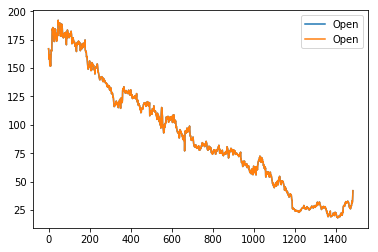

In [23]:
df_FB_[['Open','Open']].plot()

In [24]:
df_FB_[['Open','Open']].values.astype('float32')

array([[166.98, 166.98],
       [165.36, 165.36],
       [157.93, 157.93],
       ...,
       [ 32.61,  32.61],
       [ 36.53,  36.53],
       [ 42.05,  42.05]], dtype=float32)

In [25]:
df_FB_.head(3)

,Date,Open,High,Low,Close,Volume
0,2018-04-12,166.98,167.45,163.10,163.87,38262956
1,2018-04-11,165.36,168.65,163.25,166.32,56144633
2,2018-04-10,157.93,165.98,157.01,165.04,58947041


In [26]:
df_FB_['Open'].values.astype('float32')

array([166.98, 165.36, 157.93, ...,  32.61,  36.53,  42.05], dtype=float32)

In [27]:
# LSTM model dev : plot model fitting process performance 

df_FB = get_data('FB')
df_FB_ = col_fix(df_FB)
dataset = get_train_data(df_FB_)
one_input_LSTM_dev(dataset)

FB
   Unnamed: 0        Date    Open    High     Low   Close    Volume
0           0  2018-04-12  166.98  167.45  163.10  163.87  38262956
1           1  2018-04-11  165.36  168.65  163.25  166.32  56144633
2           2  2018-04-10  157.93  165.98  157.01  165.04  58947041
3           3  2018-04-09  157.82  160.53  156.04  157.93  34915227
4           4  2018-04-06  157.73  161.42  156.81  157.20  41644812
Index(['Date', ' Open', ' High', ' Low', ' Close', ' Volume'], dtype='object')
         Date    Open    High     Low   Close    Volume
0  2018-04-12  166.98  167.45  163.10  163.87  38262956
1  2018-04-11  165.36  168.65  163.25  166.32  56144633
2  2018-04-10  157.93  165.98  157.01  165.04  58947041
3  2018-04-09  157.82  160.53  156.04  157.93  34915227
4  2018-04-06  157.73  161.42  156.81  157.20  41644812
[[166.98]
 [165.36]
 [157.93]
 ...
 [ 32.61]
 [ 36.53]
 [ 42.05]]


NameError: name 'one_input_LSTM_dev' is not defined

In [28]:

def one_input_LSTM_dev(dataset):
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    # reshape into X=t and Y=t+1
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    # Compile model
    #model.compile(loss='mean_squared_error', optimizer='adam')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


    history = model.fit(trainX, trainY,validation_split=0.33, epochs=4, batch_size=10, verbose=0)
    #history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
    print (history)
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    #plt.plot(history.history['acc'])
    #plt.plot(history.history['val_acc'])
    #plt.title('model accuracy')
    #plt.ylabel('accuracy')
    #plt.xlabel('epoch')
    #plt.legend(['train', 'test'], loc='upper left')
    #plt.show()
    
    plt.plot(history.history['acc'])
    #plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


In [29]:
# ------------ TEST WITH V2 ARCHITECTURE ------------ #

In [30]:
dataset,trainPredict,testPredict,trainPredictPlot,testPredictPlot = one_input_LSTM_model_3(dataset)


NameError: name 'one_input_LSTM_model_3' is not defined

In [31]:
data = pd.read_csv('./data/AAPL.csv')[::-1] 
close_price = data.ix[:, 'Adj Close'].tolist() 
plt.plot(close_price) 
plt.show()

FileNotFoundError: File b'./data/AAPL.csv' does not exist

In [32]:
df_FB_['Open'].reshape(-1, 1)

/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


array([[166.98],
       [165.36],
       [157.93],
       ...,
       [ 32.61],
       [ 36.53],
       [ 42.05]])

In [33]:
dataset

array([[166.98],
       [165.36],
       [157.93],
       ...,
       [ 32.61],
       [ 36.53],
       [ 42.05]], dtype=float32)

In [34]:
shape(dataset_)

NameError: name 'dataset_' is not defined

In [35]:
dataset_.shape[-1]

NameError: name 'dataset_' is not defined

In [36]:
dataset_.shape[0]

NameError: name 'dataset_' is not defined

In [37]:
shape(dataset)

(1484, 1)

In [38]:
# train with V2 ARCHITECTURE


df_FB = get_data('FB')
df_FB_ = col_fix(df_FB)
# V1 dataset
dataset = get_train_data(df_FB_)
# V2 dataset
dataset_ = df_FB_['Open'].reshape(-1, 1)

model=dev_model_1()
dataset,trainPredict,testPredict,trainPredictPlot,testPredictPlot = V2_model_runner(dataset,model )


# plot fitting output 




plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
#plt.xlim(900,1400)
plt.plot( df_FB_[['Open']])
plt.show()


FB
   Unnamed: 0        Date    Open    High     Low   Close    Volume
0           0  2018-04-12  166.98  167.45  163.10  163.87  38262956
1           1  2018-04-11  165.36  168.65  163.25  166.32  56144633
2           2  2018-04-10  157.93  165.98  157.01  165.04  58947041
3           3  2018-04-09  157.82  160.53  156.04  157.93  34915227
4           4  2018-04-06  157.73  161.42  156.81  157.20  41644812
Index(['Date', ' Open', ' High', ' Low', ' Close', ' Volume'], dtype='object')
         Date    Open    High     Low   Close    Volume
0  2018-04-12  166.98  167.45  163.10  163.87  38262956
1  2018-04-11  165.36  168.65  163.25  166.32  56144633
2  2018-04-10  157.93  165.98  157.01  165.04  58947041
3  2018-04-09  157.82  160.53  156.04  157.93  34915227
4  2018-04-06  157.73  161.42  156.81  157.20  41644812
[[166.98]
 [165.36]
 [157.93]
 ...
 [ 32.61]
 [ 36.53]
 [ 42.05]]


/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


NameError: name 'dev_model_1' is not defined

In [39]:
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.callbacks import ReduceLROnPlateau


def dev_model_1():
    model = Sequential()
    model.add(Dense(1484, input_shape=(1, 1))) 
    #model.add(Dense(1484, input_dim=2)) 
    #model.add(4,input_shape=(1, 1)) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Flatten())
    model.add(Dense(1)) 
    model.add(Activation('softmax'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model 


def dev_model_2():
    model = Sequential() 
    model.add(Dense(64, input_dim=30)) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dense(16)) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dense(2)) 
    model.add(Activation('softmax'))
    return model 

def dev_model_3():
    model = Sequential() 
    model.add(Dense(64, input_dim=30,activity_regularizer=regularizers.l2(0.01))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dense(16,activity_regularizer=regularizers.l2(0.01))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dense(2)) 
    model.add(Activation('softmax'))
    return model 

def dev_model_4():
    model = Sequential()  
    model.add(Dense(64, input_dim=30,activity_regularizer=regularizers.l2(0.01))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dropout(0.5)) 
    model.add(Dense(16,activity_regularizer=regularizers.l2(0.01))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dense(2)) 
    model.add(Activation('softmax'))
    return model 





# V2 ARCHITECTURE runner 

def V2_model_runner(dataset, model):
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    # reshape into X=t and Y=t+1
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1])) 
    ####### import pre-defined model #######
    print (model) 
    # train the model 
    #history = model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1) 
    history = model.fit(trainX, trainY, nb_epoch = 50,batch_size = 128, verbose=1, validation_data=(testX, testY),shuffle=True, callbacks=[reduce_lr])
    # --------- plot the training history --------- #
    plt.figure() 
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss']) 
    plt.title('model loss') 
    plt.ylabel('loss') 
    plt.xlabel('epoch') 
    plt.legend(['train', 'test'], loc='best') 
    plt.show()
    print ('-------------------------------------')

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    print (model.summary())
    return  dataset,trainPredict,testPredict,trainPredictPlot,testPredictPlot

